In [1]:
import av

from PIL import Image, ImageEnhance
from matplotlib import pyplot as plt

import tensorflow as tf

import keras
from keras import layers
from keras.optimizers import Adam
from keras.applications.xception import Xception

import os
import random
import math
import numpy as np
import pickle

In [2]:
DS_CDFV1 = 'celeb_df_v1/'
DS_CDFV2 = 'celeb_df_v2/'

DS_ORGINAL = 'dataset_original/'
DS_SPLIT = 'dataset_split/'
DS_IFRAMES = 'dataset_iframes/'
DS_FACE = 'dataset_face/'
DS_FACE_IMG = 'dataset_face_img/'
DS_SRM_SNIPPETS = 'dataset_srm_snippets_5/'
DS_SEGMENTS = 'dataset_segments/'
DS_RAW = 'dataset_raw/'
DS_RESIDUALS = 'dataset_residuals/'
DS_TEMPORAL = 'dataset_temporal/'


SEG_1 = 'seg_1/'
SEG_2 = 'seg_2/'
SEG_3 = 'seg_3/'
SEG_4 = 'seg_4/'
SEG_5 = 'seg_5/'

SEG = ['seg_1_', 'seg_2_', 'seg_3_', 'seg_4_', 'seg_5_']

DS_TRAIN = 'train_dataset/'
DS_TEST = 'test_dataset/'
DS_VAL = 'val_dataset/'

CLASS_FAKE = 'fake/'
CLASS_REAL = 'real/'


TOP_LEVEL_1 = [DS_SPLIT, DS_IFRAMES, DS_FACE, DS_FACE_IMG, DS_SRM_SNIPPETS]
TOP_LEVEL_2 = [DS_SEGMENTS, DS_RAW, DS_RESIDUALS]
SEGMENTS = [SEG_1, SEG_2, SEG_3, SEG_4, SEG_5]
SPLIT = [DS_TRAIN, DS_TEST, DS_VAL]
CLASS = [CLASS_REAL, CLASS_FAKE]

DATASET = [DS_CDFV1, DS_CDFV2]

In [3]:
SAVE_CHECKPOINT_PATH = 'models/SRM_Model/checkpoints/'
SAVE_METRICS_PATH = 'models/SRM_Model/metrics/'
SAVE_MODEL_PATH = 'models/SRM_Model/final_model/'
BACKUP_MODEL_PATH = 'models/SRM_Model/backups/'

TEST_SCORE_PATH = 'test_scores/'

# Snippet Extraction

## Functions

In [4]:
# Returns the index of frames that begin a new segment (except the first segment)
def get_segment_dividers(frame_count, num_segments):
    segments_per_frame = math.floor(frame_count / num_segments)

    return [(segments_per_frame * i) for i in range(1, num_segments) ]

In [5]:
# Returns the indices of the frames that will be randomly selected from each segment
# Multiple snippets indices per segment can be returned by setting the num_snippets arg 
def get_snippet_indices(segment_dividers, num_snippets):
    start_index = 0
    num_snippets = 1 if num_snippets <= 0 else num_snippets

    snippet_indices = []
    for end_index in segment_dividers:

        # Extracting multiple snippets per segment (if needed)
        for _ in range(num_snippets):
            snippet_indices.append(random.randint(start_index, end_index - 1))

        start_index = end_index
        
    return snippet_indices

In [6]:
# Returns an array of randomly selected snippets(PIL.Image) from each segment of the input video
def extract_snippets(fp, num_segments, num_snippets):
    vid_container = av.open(fp)
    vid_stream = vid_container.streams.video[0]
    frame_count = vid_stream.frames

    snippets = []

    # If number of frames in video is less than the number of frames that need to sampled
    # then take all frames in the video
    if frame_count < num_segments * num_snippets:
        for frame in vid_container.decode():
            snippets.append(frame.to_image())

    else:
        segment_dividers = get_segment_dividers(frame_count, num_segments)
        segment_dividers = segment_dividers + [frame_count]

        snippet_indices = get_snippet_indices(segment_dividers, num_snippets)

        frame_index = 0
        for frame in vid_container.decode():
            if frame_index > max(snippet_indices):
                break

            if frame_index in snippet_indices:
                snippets.append(frame.to_image())

            frame_index += 1

    return snippets

## Implementation

### Celeb-DF v1 & v2

In [103]:
def save_snippets_CDF(dataset, num_segments, num_snippets):
    if dataset != DS_CDFV1 and dataset != DS_CDFV2:
        print(dataset)
        return
    
    random.seed(1)
    
    src_base_path = dataset + DS_FACE
    dst_base_path = dataset + DS_SRM_SNIPPETS

    for split in SPLIT:
        print(f'---Split started: {split}---')
        for class_dir in CLASS:
            print(f'Class started: {class_dir}')

            for video in os.listdir(src_base_path + split + class_dir):
                fp = src_base_path + split + class_dir + video
                snippets = extract_snippets(fp, num_segments, num_snippets)

                for i, snippet in enumerate(snippets, start=1):
                    seg_index = math.ceil(float(i) / num_snippets)
                    snip_index = (i - 1) % num_snippets
              
                    dst = f'{dst_base_path + split + class_dir + os.path.splitext(video)[0]}_s{seg_index}_f{snip_index}.jpeg'
                    snippet.save(dst)         

In [85]:
# CELEB DF V1
save_snippets_CDF(DS_CDFV1, num_segments=5, num_snippets=1)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


In [104]:
# CELEB DF V2
save_snippets_CDF(DS_CDFV2, num_segments=5, num_snippets=1)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


# Data Augmentation (Train)

In [16]:
def flip_and_save_image(dataset, split, class_dir):
    img_dir = dataset + DS_SRM_SNIPPETS + split + class_dir

    count = 0
    files = os.listdir(img_dir)
    for file in files:
        image = Image.open(img_dir + file)
        image_flipped = image.transpose(Image.FLIP_LEFT_RIGHT)

        image_flipped.save(img_dir + os.path.splitext(file)[0] + '_flip.jpeg')
        count += 1

    print(f'{len(files)} files found.')
    print(f'{count} files flipped.')

In [21]:
def increase_brightness(dataset, split, class_dir, factor):
    img_dir = dataset + DS_SRM_SNIPPETS + split + class_dir
    for file in os.listdir(img_dir):
        image = Image.open(img_dir + file)

        enhancer = ImageEnhance.Brightness(image)
        image_enhanced = enhancer.enhance(factor)

        image_enhanced.save(img_dir + os.path.splitext(file)[0] + '_enhanced.jpeg')


In [ ]:
flip_and_save_image(DS_CDFV2, DS_TRAIN, CLASS_REAL)

In [23]:
increase_brightness(DS_CDFV2, DS_TRAIN, CLASS_REAL, 1.5)

# Tensor Dataset Creation

In [7]:
def create_tensor_dataset(dataset, split):
    ds = keras.utils.image_dataset_from_directory(
        directory = dataset + DS_SRM_SNIPPETS + split,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 32,
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

    return ds

## Celeb DF v1

In [8]:
train_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_TRAIN)
test_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_TEST)
val_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_VAL)

Found 4415 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 1100 files belonging to 2 classes.


## Celeb DF v2

In [8]:
train_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TRAIN)
test_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TEST)
val_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_VAL)

Found 32584 files belonging to 2 classes.
Found 2590 files belonging to 2 classes.
Found 6005 files belonging to 2 classes.


# Model Creation

**In Convolution**
- Input Shape:  [batch_size, height, width, channels]
- Filter Shape: [height, width, in_channels, filter_count]

## Functions

In [9]:
class SRMLayer(keras.layers.Layer):
    def __init__(self, strides=[1,1,1,1], padding='SAME'):
        super(SRMLayer, self).__init__()
        self.strides = strides
        self.padding = padding

        # Set of 3 fixed SRM Filters used to extract noise & semantic features
        self.filter_small = tf.constant([[0, 0,  0, 0, 0],
                                         [0, 0,  0, 0, 0],
                                         [0, 1, -2, 1, 0],
                                         [0, 0,  0, 0, 0],
                                         [0, 0,  0, 0, 0]], dtype=tf.float32)
        
        self.filter_med = tf.constant([[0,  0,  0,  0, 0],
                                       [0, -1,  2, -1, 0],
                                       [0,  2, -4,  2, 0],
                                       [0, -1,  2, -1, 0],
                                       [0,  0,  0,  0, 0]], dtype=tf.float32)
        
        self.filter_large = tf.constant([[-1,  2,  -2,  2, -1],
                                         [ 2, -6,   8, -6,  2],
                                         [-2,  8, -12,  8, -2],
                                         [ 2, -6,   8, -6,  2],
                                         [-1,  2,  -2,  2, -1]], dtype=tf.float32)

        # Learnability in SRM filters introduced by 'q' values
        # SRM filters are divided by their respective 'q' values before convolution
        # 'q' values are updated during backpropagation using gradient descent
        self.q_small = self.add_weight(name='q_small',
                                       shape=(5, 5, 3, 1),
                                       initializer=keras.initializers.Constant(value=2.0),
                                       trainable=True)
        
        self.q_med = self.add_weight(name='q_med',
                                     shape=(5, 5, 3, 1),
                                     initializer=keras.initializers.Constant(value=4.0),
                                     trainable=True)
        
        self.q_large = self.add_weight(name='q_large',
                                       shape=(5, 5, 3, 1),
                                       initializer=keras.initializers.Constant(value=12.0),
                                       trainable=True)
        
        # 3rd dimension of filters => number of input channels (Three channels)
        self.filter_small = tf.stack([self.filter_small, self.filter_small, self.filter_small], axis=2)
        self.filter_med   = tf.stack([self.filter_med, self.filter_med, self.filter_med], axis=2)
        self.filter_large = tf.stack([self.filter_large, self.filter_large, self.filter_large], axis=2)

        # 4th dimension of filters => number of output feature maps (One feature map)
        # Each filter gives a single output feature map
        self.filter_small = tf.expand_dims(self.filter_small, axis=-1)
        self.filter_med   = tf.expand_dims(self.filter_med, axis=-1)
        self.filter_large = tf.expand_dims(self.filter_large, axis=-1)
        
    def call(self, inputs):
        filter_small = tf.math.divide(self.filter_small, self.q_small)
        filter_med   = tf.math.divide(self.filter_med, self.q_med)
        filter_large = tf.math.divide(self.filter_large, self.q_large)

        output_small = tf.nn.conv2d(inputs, filter_small, strides=self.strides, padding=self.padding)
        output_med   = tf.nn.conv2d(inputs, filter_med,   strides=self.strides, padding=self.padding)
        output_large = tf.nn.conv2d(inputs, filter_large, strides=self.strides, padding=self.padding)

        return tf.concat([output_small, output_med, output_large], axis=3)

    def get_config(self):
        config = super(SRMLayer, self).get_config()
        config.update({'strides': self.strides,
                       'padding': self.padding,
                       'filter_small': self.filter_small,
                       'filter_med': self.filter_med,
                       'filter_large': self.filter_large,
                       'q_small': self.q_small,
                       'q_med': self.q_med,
                       'q_large': self.q_large})
        
        return config


In [10]:
XceptionNetwork = keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
    pooling = max,
    classes = 2
)

In [11]:
class MetricsCheckPoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        metrics_dict = {}
        if os.path.exists(SAVE_METRICS_PATH + 'metrics.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        with open(SAVE_METRICS_PATH + 'metrics.pkl', 'wb') as f:
            pickle.dump(metrics_dict, f)

In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = SAVE_CHECKPOINT_PATH + 'checkpoint',
    save_weights_only = True
)

In [13]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience = 5,
    restore_best_weights = True,
    start_from_epoch = 50
)

In [14]:
model_restore_callback = keras.callbacks.BackupAndRestore(
    backup_dir = BACKUP_MODEL_PATH + 'backup'
)

## Implementation

### Model Creation

In [15]:
# Ensuring all layers are trainable (fine-tuning)
XceptionNetwork.trainable = True

# TODO: Freezing all BN layers except for first one (can be done better)
# Freeze all BN layers
for layer in XceptionNetwork.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Unfreeze first BN layer
for layer in XceptionNetwork.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        break

In [16]:
seen_first = False
for layer in XceptionNetwork.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        if seen_first == False:
            assert layer.trainable == True
            seen_first = True
        else:
            assert layer.trainable == False

In [17]:
def create_SRM_model(xception_training):
    inputs = keras.layers.Input(shape=(256, 256, 3))
    SRM_noise_maps = SRMLayer()(inputs)
    
    feature_maps = tf.keras.applications.xception.preprocess_input(SRM_noise_maps)
    feature_maps = XceptionNetwork(feature_maps, training=xception_training)

    features = keras.layers.Flatten()(feature_maps)
    features = keras.layers.Dropout(0.8)(features)
    features = keras.layers.Dense(units=130, activation=keras.layers.LeakyReLU())(features)
    outputs = keras.layers.Dense(units=1, activation='sigmoid')(features)

    return keras.Model(inputs, outputs, name='SRM_Model')

In [18]:
SRM_Model = create_SRM_model(xception_training=False)

In [21]:
optimizer = keras.optimizers.Adam(beta_1=0.9, 
                                  beta_2=0.999, 
                                  epsilon=1e-6, 
                                  learning_rate=0.00002)

SRM_Model.compile(optimizer=optimizer,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=[keras.metrics.BinaryAccuracy(), 
                               keras.metrics.Precision(), 
                               keras.metrics.Recall(),
                               keras.metrics.AUC(),
                               keras.metrics.FalseNegatives(),
                               keras.metrics.FalsePositives(),
                               keras.metrics.TrueNegatives(),
                               keras.metrics.TruePositives()])

SRM_Model.summary()

Model: "SRM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 srm_layer (SRMLayer)        (None, 256, 256, 3)       225       
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0 

### Training SRM and Dense Layers

In [52]:
def train_model(model, train_ds, val_ds, max_epochs):
    history = model.fit(train_ds,
                        epochs = max_epochs,
                        validation_data = val_ds,
                        callbacks = [model_checkpoint_callback, 
                                     early_stopping_callback,
                                     model_restore_callback,
                                     MetricsCheckPoint()])
    
    return history, model

In [ ]:
history, SRM_Model = train_model(SRM_Model, train_dataset_cdfv1, val_dataset_cdfv1, 2)

### Saving & Loading Model

In [22]:
SRM_Model.save_weights(SAVE_MODEL_PATH + 'model')

In [22]:
SRM_Model.load_weights(SAVE_MODEL_PATH + 'model')

# Model Metrics

## Training Metrics

In [19]:
metrics = {}
with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

acc = metrics['binary_accuracy']
val_acc = metrics['val_binary_accuracy']

precision = metrics['precision']
val_precision = metrics['val_precision']

recall = metrics['recall']
val_recall = metrics['val_recall']

auc = metrics['auc']
val_auc = metrics['val_auc']

loss = metrics['loss']
val_loss = metrics['val_loss']

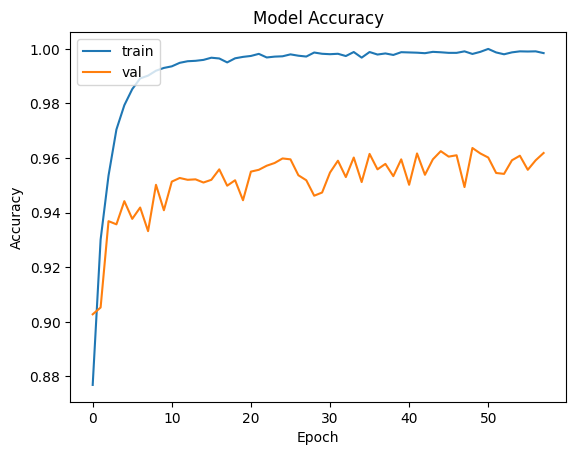

In [20]:
plt.plot(acc)
plt.plot(val_acc)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

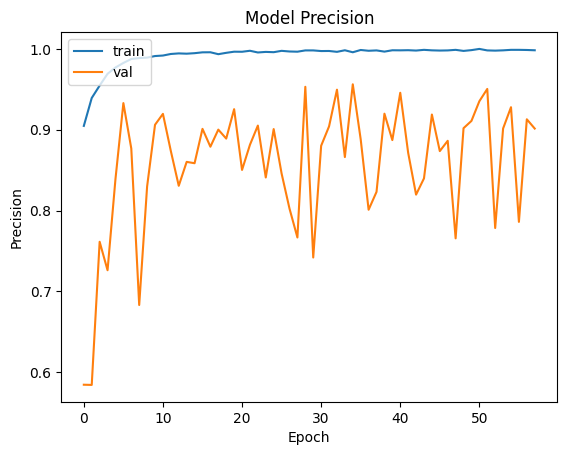

In [21]:
plt.plot(precision)
plt.plot(val_precision)

plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

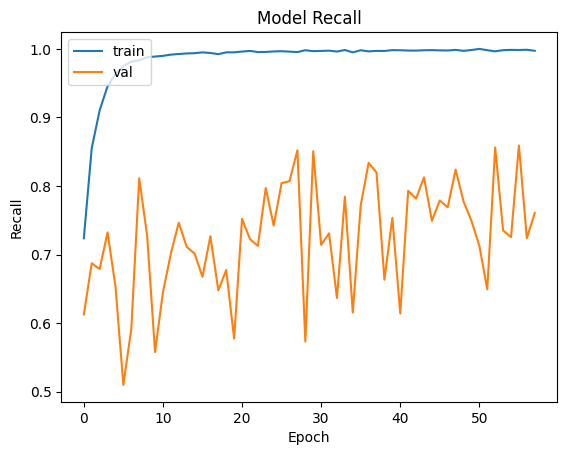

In [22]:
plt.plot(recall)
plt.plot(val_recall)

plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

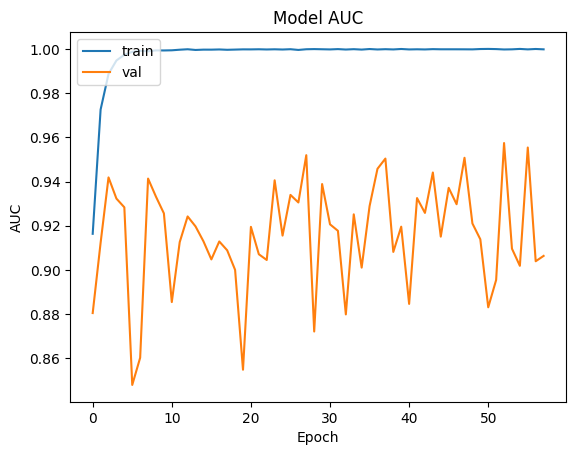

In [23]:
plt.plot(auc)
plt.plot(val_auc)

plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

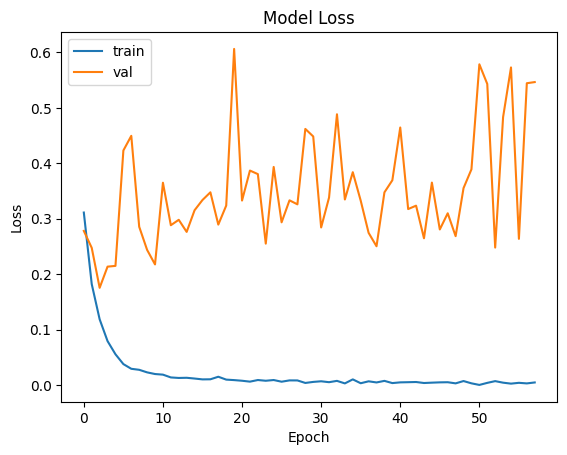

In [24]:
plt.plot(loss)
plt.plot(val_loss)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing Metrics (Frame Level)

In [23]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = SRM_Model.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

81/81 [==============================] - 424s 5s/step - loss: 0.4460 - binary_accuracy: 0.9263 - precision: 0.9176 - recall: 0.8629 - auc: 0.9537 - false_negatives: 122.0000 - false_positives: 69.0000 - true_negatives: 1631.0000 - true_positives: 768.0000
Loss: 0.4460
Accuracy: 0.9263
Precision: 0.9176
Recall: 0.8629
AUC: 0.9537
--------------------
False Positives: 69.0
False Negatives: 122.0
True Positives: 768.0
True Negatives: 1631.0


## Testing Metrics (Video Level)

In [34]:
from sklearn import metrics

### Functions

In [27]:
class VideoScore():
    def __init__(self, filename, score, true_class, fake_on_lower_half = True):
        self.filename = filename
        self.score = score
        self.true_class = true_class
        self.fake_on_lower_half = fake_on_lower_half

    def get_filename(self):
        return self.filename
    
    def get_score(self):
        return self.score
    
    def get_true_class(self):
        return self.true_class
    
    def get_fake_on_lower_half(self):
        return self.fake_on_lower_half

In [29]:
def calculate_video_score(model, fp):
    frames = extract_snippets(fp, num_segments=8, num_snippets=1)

    tf_frames = []
    for frame in frames:
        tf_frames.append(tf.convert_to_tensor(frame))

    tf_frames = tf.convert_to_tensor(tf_frames)
    results = model.predict(tf_frames, verbose=0)

    return np.average(results)

In [30]:
def calculate_scores(dataset, split, model):
    video_scores = []

    for class_dir in CLASS:
        print(f'Class started: {class_dir}')
    
        vid_dir = dataset + DS_FACE + split + class_dir
        for video in os.listdir(vid_dir):
            fp = vid_dir + video

            video_score = VideoScore(video, 
                                    calculate_video_score(model, fp),
                                    class_dir)
            
            video_scores.append(video_score)

    return video_scores

In [31]:
def calculate_metrics(scores):
    true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

    for vid_score in scores:
        score = vid_score.get_score()
        if score < 0.5 and vid_score.get_true_class() == CLASS_FAKE:
            true_fake += 1

        elif score >= 0.5 and vid_score.get_true_class() == CLASS_REAL:
            true_real += 1

        elif score < 0.5 and vid_score.get_true_class() == CLASS_REAL:
            false_fake += 1

        else:
            false_real += 1

    accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)
    precision = true_fake / (true_fake + false_fake)
    recall = true_fake / (true_fake + false_real)


    y_true = [0 if x.get_true_class() == CLASS_FAKE else 1 for x in scores]
    y_score = [0 if x.get_score() < 0.5 else 1 for x in scores]

    auc = metrics.roc_auc_score(y_true, y_score)

    all_metrics = {}
    all_metrics['true_fake'] = true_fake    
    all_metrics['true_real'] = true_real
    all_metrics['false_fake'] = false_fake
    all_metrics['false_real'] = false_real
    all_metrics['accuracy'] = accuracy
    all_metrics['precision'] = precision
    all_metrics['recall'] = recall
    all_metrics['AUC'] = auc

    return all_metrics

### Measuring and saving metrics

In [25]:
SRM_Model_test_scores = calculate_scores(DS_CDFV2, DS_TEST, SRM_Model)
SRM_Model_train_scores = calculate_scores(DS_CDFV2, DS_TRAIN, SRM_Model)

with open(TEST_SCORE_PATH + 'srm_scores_test.pkl', 'wb') as f:
    pickle.dump(SRM_Model_test_scores, f)

with open(TEST_SCORE_PATH + 'srm_scores_train.pkl', 'wb') as f:
    pickle.dump(SRM_Model_train_scores, f)

Class started: real/
Class started: fake/


### Test Results

In [35]:
with open(TEST_SCORE_PATH + 'srm_scores_test', 'rb') as f:
    SRM_Model_test_scores = pickle.load(f)

In [36]:
all_metrics = calculate_metrics(SRM_Model_test_scores)

In [37]:
print(f'True Fake:{all_metrics["true_fake"]}')
print(f'True Real:{all_metrics["true_real"]}')
print(f'False Fake:{all_metrics["false_fake"]}')
print(f'False Real:{all_metrics["false_real"]}')
print(f'---')
print(f'Accuracy: {all_metrics["accuracy"]:.4f}')
print(f'Precision: {all_metrics["precision"]:.4f}')
print(f'Recall: {all_metrics["recall"]:.4f}')
print(f'AUC Score: {all_metrics["AUC"]:.4f}')

True Fake:340
True Real:126
False Fake:52
False Real:0
---
Accuracy: 0.8996
Precision: 0.8673
Recall: 1.0000
AUC Score: 0.8539
